In [ ]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__) # Try to use 0.24

Pandas   1.2.4
Sklearn  0.24.2


### Importing Dataset

In [ ]:
CLOUD = False

if CLOUD:
    import os
    os.environ['KAGGLE_USERNAME'] = "umutakta"
    os.environ['KAGGLE_KEY']      = "a471e5474add8d57cadac3cc5ff2b1d6"  
    !pip install --upgrade kaggle
    !kaggle competitions download -c competitive-data-science-predict-future-sales
    DATA_PATH = "/work/Strive_School/Feature_Engineering_(Module_4)/Day_6_Feature_Selection/competitive-data-science-predict-future-sales/"

else:
    DATA_PATH = "/work/Data_Sets/competitive-data-science-predict-future-sales/"

DATA_PATH

'/work/Data_Sets/competitive-data-science-predict-future-sales/'

**Creating Data Frame**

In [ ]:
df_item_categ=pd.read_csv(DATA_PATH+"item_categories.csv")
df_items=pd.read_csv(DATA_PATH+"items.csv")
df=pd.read_csv(DATA_PATH+"sales_train.csv")
df_sample=pd.read_csv(DATA_PATH+"sample_submission.csv")
df_shops=pd.read_csv(DATA_PATH+"shops.csv")
df_test=pd.read_csv(DATA_PATH+"test.csv")

In [ ]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Turning date column to **date type**

In [ ]:
from datetime import datetime

df["date"]=df['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))


### Deleting Outliers

**Item Count Day**

In [ ]:
df=df.drop(df.loc[df.item_cnt_day<0].index.tolist())

<AxesSubplot:xlabel='item_cnt_day'>

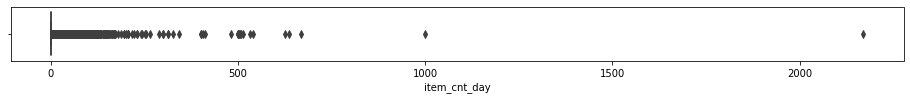

In [ ]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_cnt_day)

**Item Price**

In [ ]:
for i in range(5):
    df=df.drop(df.index[df.loc[df.item_price==df.item_price.max()].index[0]])

<AxesSubplot:xlabel='item_price'>

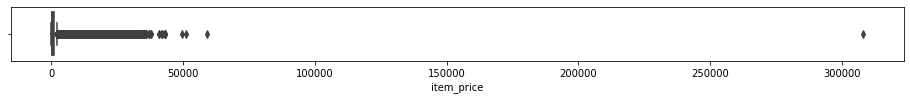

In [ ]:
plt.figure(figsize=(16,1))
sb.boxplot(x=df.item_price)

#### Creating new data frame for only 2013,2014,2015

In [ ]:
df_2013=df[(df.date<"01-01-2014") & ("31-12-2012"<df.date)]
df_2014=df[(df.date<"01-01-2015") & ("31-12-2013"<df.date)]
df_2015=df[(df.date<"01-01-2016") & ("31-12-2014"<df.date)]

** Grouping monthly sales **

In [ ]:
df_2013['total_income_13']=df_2013.item_price*df_2013.item_cnt_day
df13_total=df_2013.groupby(['date_block_num']).sum()

df_2014['total_income_14']=df_2014.item_price*df_2014.item_cnt_day
df14_total=df_2014.groupby(['date_block_num']).sum()

df_2015['total_income_15']=df_2015.item_price*df_2015.item_cnt_day
df15_total=df_2015.groupby(['date_block_num']).sum()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

** Plot by total income for 2013 and 2014**

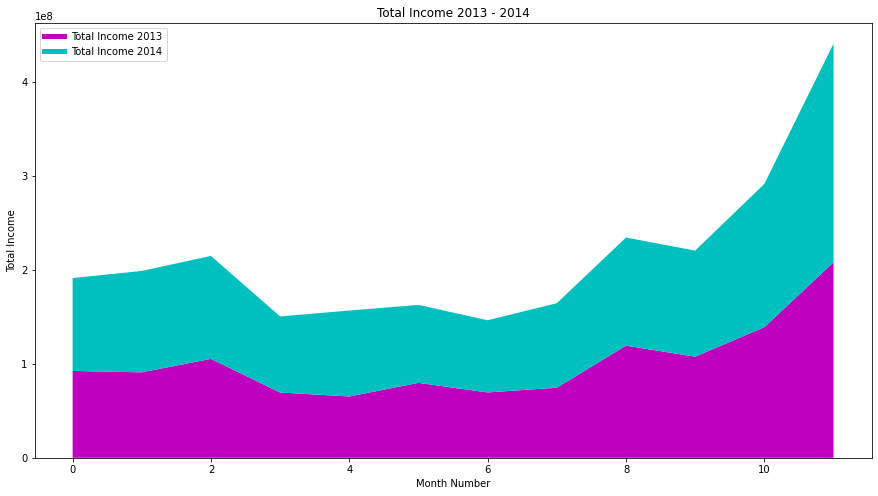

In [ ]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='m', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='c', label='Total Income 2014', linewidth=5)

plt.stackplot(df13_total.index, df13_total.total_income_13, df14_total.total_income_14,colors=['m','c'])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

** Total Income Plotting Until October in 2013,2014 and 2015 **

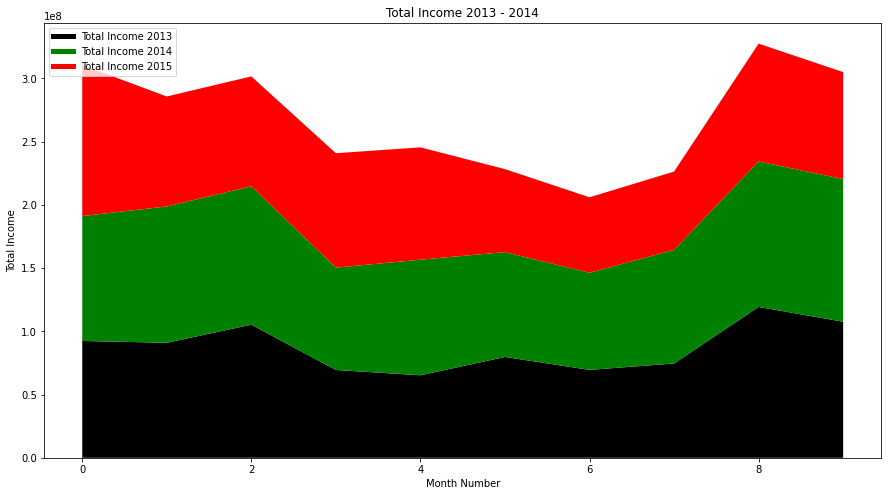

In [ ]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='k', label='Total Income 2013', linewidth=5)
plt.plot([],[],color='g', label='Total Income 2014', linewidth=5)
plt.plot([],[],color='r', label='Total Income 2015', linewidth=5)

plt.stackplot(df13_total.index[:10], df13_total.loc[:9].total_income_13, 
    df14_total.loc[:21].total_income_14,df15_total.total_income_15,colors=['k','g',"r"])

plt.xlabel('Month Number')
plt.ylabel('Total Income')
plt.title('Total Income 2013 - 2014')
plt.legend(loc='upper left')
plt.show()

#### Interesting with shop id

Finding different shops between years 2013, 2014 and 2015

In [ ]:
set_difference_13_14 = set(df_2013.shop_id.unique()) - set(df_2014.shop_id.unique())
difference_13_14 = list(set_difference_13_14)

set_difference_13_15 = set(df_2013.shop_id.unique()) - set(df_2015.shop_id.unique())
difference_13_15 = list(set_difference_13_15)

difference_13_14.extend(difference_13_15)
difference_13=difference_13_14
difference_13

[0, 1, 32, 8, 23, 0, 1, 32, 8, 13, 23]

In [ ]:
set_difference_14_15 = set(df_2014.shop_id.unique()) - set(df_2015.shop_id.unique())
difference_14_15 = list(set_difference_14_15)

set_difference_14_13 = set(df_2014.shop_id.unique()) - set(df_2013.shop_id.unique())
difference_14_13 = list(set_difference_14_13)

difference_14_13.extend(difference_14_15)
difference_14=difference_14_13
difference_14

[33, 34, 39, 40, 48, 20, 13]

In [ ]:
set_difference_15_13 = set(df_2015.shop_id.unique()) - set(df_2013.shop_id.unique())
difference_15_13 = list(set_difference_15_13)

set_difference_15_14 = set(df_2015.shop_id.unique()) - set(df_2014.shop_id.unique())
difference_15_14 = list(set_difference_15_14)

difference_15_14.extend(difference_15_13)
difference_15=difference_15_14
difference_15

[11, 36, 33, 34, 36, 39, 40, 11, 48, 20]

In [ ]:
# Dropping different shops from 2013 and 2014
df_2013_drop_shops=df_2013.groupby(["shop_id"]).sum().drop(difference_13, axis=0)
df_2014_drop_shops=df_2014.groupby(["shop_id"]).sum().drop(difference_14, axis=0)
df_2015_drop_shops=df_2015.groupby(["shop_id"]).sum().drop(difference_15, axis=0)

** Plot Total Income Per Shop **

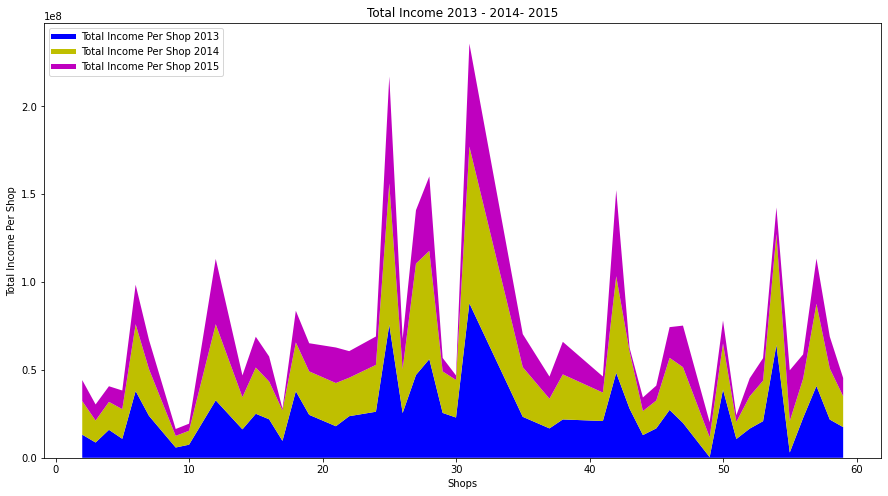

In [ ]:
plt.subplots(figsize=(15,8))

plt.plot([],[],color='b', label='Total Income Per Shop 2013', linewidth=5)
plt.plot([],[],color='y', label='Total Income Per Shop 2014', linewidth=5)
plt.plot([],[],color='m', label='Total Income Per Shop 2015', linewidth=5)

plt.stackplot(df_2013_drop_shops.index, df_2013_drop_shops.total_income_13, 
    df_2014_drop_shops.total_income_14,df_2015_drop_shops.total_income_15,colors=['b','y',"m"])

plt.xlabel('Shops')
plt.ylabel('Total Income Per Shop')
plt.title('Total Income 2013 - 2014- 2015')
plt.legend(loc='upper left')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=796ba814-f632-4502-b0d7-7e2f8f9e546d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>